# Books Recommender System#

## Popularity and  User-Based Collaborative Filtering##

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Import libraries and datasets ##

In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#link to datasets
books = pd.read_csv('drive/My Drive/Colab Notebooks/books.csv')
books = books.drop(['image_url','small_image_url','title','best_book_id','isbn','isbn13'],axis=1)
ratings_data = pd.read_csv('drive/My Drive/Colab Notebooks/ratings.csv')

#merge the rating with book based on book id
books_data = pd.merge(ratings_data,books,on='book_id')
books_data= books_data.drop(['id','work_id','language_code','work_ratings_count','work_text_reviews_count','ratings_1','ratings_2','ratings_3','ratings_4','ratings_5'],axis=1)

#remove warning message
import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing ##

#### Data Cleaning ####

In [3]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   work_id                    10000 non-null  int64  
 3   books_count                10000 non-null  int64  
 4   authors                    10000 non-null  object 
 5   original_publication_year  9979 non-null   float64
 6   original_title             9415 non-null   object 
 7   language_code              8916 non-null   object 
 8   average_rating             10000 non-null  float64
 9   ratings_count              10000 non-null  int64  
 10  work_ratings_count         10000 non-null  int64  
 11  work_text_reviews_count    10000 non-null  int64  
 12  ratings_1                  10000 non-null  int64  
 13  ratings_2                  10000 non-null  int6

In [4]:
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB


In [5]:
books_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79701 entries, 0 to 79700
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    79701 non-null  int64  
 1   user_id                    79701 non-null  int64  
 2   rating                     79701 non-null  int64  
 3   books_count                79701 non-null  int64  
 4   authors                    79701 non-null  object 
 5   original_publication_year  79601 non-null  float64
 6   original_title             77920 non-null  object 
 7   average_rating             79701 non-null  float64
 8   ratings_count              79701 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 6.1+ MB


In [6]:
#check missing value
nullValue = books_data.isnull().any()
nullValue

book_id                      False
user_id                      False
rating                       False
books_count                  False
authors                      False
original_publication_year     True
original_title                True
average_rating               False
ratings_count                False
dtype: bool

In [7]:
# Drops missing values for all columns if there is any missing value
books_data = books_data.dropna(how='any')

# Remove rows with non-ASCII characters in title and authors column
books_data = books_data[~books_data.original_title.str.contains(r'[^\x00-\x7F]')]
books_data = books_data[~books_data.authors.str.contains(r'[^\x00-\x7F]')]

# Resets the index
books_data = books_data.reset_index(drop=True)

#### Data visualization ####

In [8]:
#display information about books 
books_data.head()

,book_id,user_id,rating,books_count,authors,original_publication_year,original_title,average_rating,ratings_count
0,10,3662,4,6,J.K. Rowling,2005.0,"Harry Potter Collection (Harry Potter, #1-6)",4.73,24618
1,10,3922,5,6,J.K. Rowling,2005.0,"Harry Potter Collection (Harry Potter, #1-6)",4.73,24618
2,10,4536,2,6,J.K. Rowling,2005.0,"Harry Potter Collection (Harry Potter, #1-6)",4.73,24618
3,10,5115,4,6,J.K. Rowling,2005.0,"Harry Potter Collection (Harry Potter, #1-6)",4.73,24618
4,10,5272,3,6,J.K. Rowling,2005.0,"Harry Potter Collection (Harry Potter, #1-6)",4.73,24618


In [9]:
books_data.shape

(71032, 9)

In [10]:
books_data.columns

Index(['book_id', 'user_id', 'rating', 'books_count', 'authors',
       'original_publication_year', 'original_title', 'average_rating',
       'ratings_count'],
      dtype='object')

In [11]:
len(books_data)

71032

In [12]:
no_of_users = len(ratings_data.user_id.unique())
no_of_users

53424

In [13]:
no_of_books = len(ratings_data.book_id.unique())
no_of_books

10000

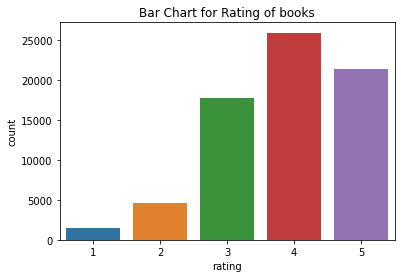

In [14]:
#the rating of books
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(books_data.rating)
plt.title('Bar Chart for Rating of books')
plt.show()

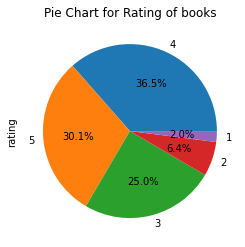

In [15]:
#pie chart for the ratings of books
plt.title('Pie Chart for Rating of books')
books_data.rating.value_counts().plot(kind='pie', autopct='%1.1f%%')

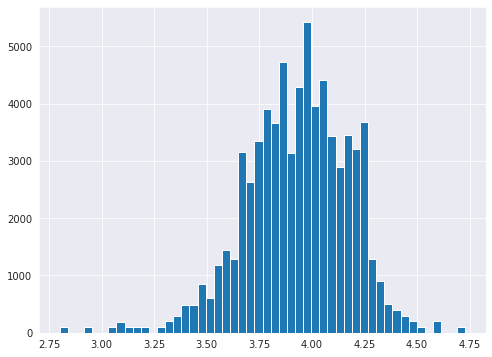

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline

#plot the histogram for average ratings
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
books_data['average_rating'].hist(bins=50)

## Popularity Based Recommender System ##

#### Recommend Top n Popular Books ####

In [21]:
#trend the books with high rating
trend = (books_data.sort_values('rating',ascending=False))
top = trend
top['books'] = top['original_title'].map(str) + " - " + top['authors']
top = top.drop(['user_id','books_count', 'authors','original_publication_year', 'original_title', 'average_rating'],axis=1)

#recommend top n popular books
n =10
print("                              TOP {} RECOMMENDATIONS".format(n))
print("===================================++++++++++++++====================================")
top.drop_duplicates().head(n)

                              TOP 10 RECOMMENDATIONS
===================================++++++++++++++====================================


,book_id,rating,ratings_count,books
52784,7035,5,29574,Morality for Beautiful Girls - Alexander McCal...
20389,3462,5,142092,The Rescue - Nicholas Sparks
20405,3463,5,116800,A Bend in the Road - Nicholas Sparks
49699,6628,5,24870,The Big Over Easy - Jasper Fforde
49747,6656,5,74130,"La Divina Commedia - Dante Alighieri, Allen Ma..."
49519,6613,5,22278,Four Blondes - Candace Bushnell
20548,3464,5,62840,True Believer - Nicholas Sparks
49560,6614,5,35792,Lipstick Jungle - Candace Bushnell
20604,3465,5,32208,"Three Weeks with My Brother - Nicholas Sparks,..."
20055,3431,5,449501,The Five People You Meet in Heaven - Mitch Albom


In [23]:
#recommend the books according to their average ratings
print("                                          Recommendations based on Average rating")
print("===================================================++++++++++++++=====================================================")
average = books_data
average = average.drop_duplicates(subset = 'book_id',keep = 'first')
average = average.drop(['user_id','rating','books_count','original_publication_year'], axis=1)
average.sort_values('average_rating',ascending=False).head(10)

                                          Recommendations based on Average rating
===================================================++++++++++++++=====================================================


,book_id,authors,original_title,average_rating,ratings_count
0,10,J.K. Rowling,"Harry Potter Collection (Harry Potter, #1-6)",4.73,24618
1000,30,J.R.R. Tolkien,The Hobbit and The Lord of the Rings,4.59,90907
2100,119,Gary Russell,The Lord of the Rings: The Art of The Fellowsh...,4.59,24340
41617,5417,Stephen King,Three Complete Novels: Carrie/Salem's Lot/The ...,4.52,11063
1100,33,J.R.R. Tolkien,The Lord of the Rings,4.47,389054
21793,3586,"Arthur Conan Doyle, Kyle Freeman",Sherlock Holmes: The Complete Novels and Stori...,4.46,66857
38844,5289,"Oscar Wilde, Merlin Holland",Collected Works,4.45,10835
21693,3581,Arthur Conan Doyle,Sherlock Holmes: The Complete Novels and Stori...,4.45,17950
44999,5936,"Pablo Neruda, Ilan Stavans",The Poetry of Pablo Neruda,4.44,14596
21593,3579,L.M. Montgomery,The Complete Anne of Green Gables Boxed Set,4.42,92142


In [24]:
#recommend based on ratings_count
print("                                      Most Rated Books")
print("=======================================++++++++++++++=========================================")
most_rated_books = books_data
most_rated_books = most_rated_books.drop_duplicates(subset = 'book_id',keep = 'first')
most_rated_books = most_rated_books.drop(['user_id','rating','books_count','original_publication_year'], axis=1)
most_rated_books.sort_values('ratings_count',ascending=False).head(10)

                                      Most Rated Books
=======================================++++++++++++++=========================================


,book_id,authors,original_title,average_rating,ratings_count
16398,2657,Harper Lee,To Kill a Mockingbird,4.25,3198671
30251,4671,F. Scott Fitzgerald,The Great Gatsby,3.89,2683664
44899,5907,J.R.R. Tolkien,The Hobbit or There and Back Again,4.25,2071616
35360,5107,J.D. Salinger,The Catcher in the Rye,3.79,2044241
12400,1885,Jane Austen,Pride and Prejudice,4.24,2035490
7900,960,Dan Brown,Angels & Demons,3.85,2001311
56303,7613,George Orwell,Animal Farm: A Fairy Story,3.87,1881700
1200,34,J.R.R. Tolkien,The Fellowship of the Ring,4.34,1766803
56403,7624,William Golding,Lord of the Flies,3.64,1605019
7300,890,John Steinbeck,Of Mice and Men,3.84,1467496


### Get Customer Input for Recommendation ###

#### Get Customer Input for Authors Name and Recommend based on Popularity ####

In [32]:
#get Customer input for their favourite authors name and recommend the books with the authors name based on popularity

authors_input = input("Enter the name of authors that you are interested: ")
author_recommend = books_data[books_data.authors == (authors_input)]
author_recommend = author_recommend.drop_duplicates(subset = 'book_id',keep = 'first')
author_recommend = author_recommend.drop(['user_id'],axis=1)
author_recommend.sort_values('rating',ascending=False).head()

Enter the name of authors that you are interested: Kurt Vonnegut Jr.


,book_id,rating,books_count,authors,original_publication_year,original_title,average_rating,ratings_count
33041,4979,5,64,Kurt Vonnegut Jr.,2005.0,A Man Without a Country,4.07,29859
33239,4981,5,241,Kurt Vonnegut Jr.,1969.0,"Slaughterhouse-Five, or The Children's Crusade...",4.06,846488
33627,4985,5,67,Kurt Vonnegut Jr.,1968.0,Welcome to the Monkey House,4.13,40071
68204,9589,5,76,Kurt Vonnegut Jr.,1990.0,Hocus Pocus,3.81,23046
68577,9595,5,65,Kurt Vonnegut Jr.,1976.0,Slapstick,3.87,27371


#### Get Customer Input for Original Publication Year and Recommend based on Popularity ####

In [33]:
#get Customer input for their original publication year and recommend the books with the authors name based on popularity

year_input = int(input("Enter the name of original publication year that you are interested: "))
book_recommend = books_data[books_data.original_publication_year == (year_input)]
book_recommend = book_recommend.drop_duplicates(subset = 'book_id',keep = 'first')
book_recommend = book_recommend.drop(['user_id'],axis=1)
book_recommend.sort_values('rating',ascending=False).head()

Enter the name of original publication year that you are interested: 2000


,book_id,rating,books_count,authors,original_publication_year,original_title,average_rating,ratings_count
37951,5190,5,37,Elizabeth Berg,2000.0,Open House,3.68,48639
16098,2612,5,100,Malcolm Gladwell,2000.0,The Tipping Point: How Little Things Can Make ...,3.92,490504
19398,3368,5,44,Steve Krug,2000.0,Don't Make Me Think! A common sense approach t...,4.24,7296
65051,8965,5,78,Darren Shan,2000.0,"The Vampire's Assistant (Cirque du Freak, #2)",4.12,29943
62690,8680,5,38,Tom Robbins,2000.0,Fierce Invalids Home From Hot Climates,4.01,22847


##Content-Based Filtering##

#### Get Customer Input for Original Title and Recommend Similar Books based on Popularity ####

In [25]:
#split the datasets into training(80%) and testing(20%)
from sklearn.model_selection import train_test_split
train, test = train_test_split(books_data, test_size=0.2)

In [34]:
#Class for Item similarity based Recommender System model
class item_similarity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.book_id = None
        self.cooccurence_matrix = None
        self.books_dict = None
        self.rev_books_dict = None
        self.item_similarity_recommendations = None
        
    #Get unique items (books) corresponding to a given user
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data[self.user_id] == user]
        user_items = list(user_data[self.book_id].unique())
        
        return user_items
        
    #Get unique users for a given item (books)
    def get_item_users(self, item):
        item_data = self.train_data[self.train_data[self.book_id] == item]
        item_users = set(item_data[self.user_id].unique())
            
        return item_users
        
    #Get unique items (books) in the training data
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.book_id].unique())
            
        return all_items
        
    #Construct cooccurence matrix
    def construct_cooccurence_matrix(self, user_books, all_books):
            
        ####################################
        #Get users for all books in user_books.
        ####################################
        user_books_users = []        
        for i in range(0, len(user_books)):
            user_books_users.append(self.get_item_users(user_books[i]))
            
        ###############################################
        #cooccurence matric is an item-item matrix
        #each element means how many times both items bought together by a user
        #Initialize the item cooccurence matrix of size 
        #len(user_books) X len(books)
        ###############################################
        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_books), len(all_books))), float)
           
        #############################################################
        #Calculate similarity between user books and all unique books
        #in the training data
        #############################################################
        for i in range(0,len(all_books)):
            #Calculate users of books (item) i
            books_i_data = self.train_data[self.train_data[self.book_id] == all_books[i]]
            users_i = set(books_i_data[self.user_id].unique())
            
            for j in range(0,len(user_books)):       
                    
                #Get unique users of books (item) j
                users_j = user_books_users[j]
                    
                #Calculate intersection of users of books i and j
                users_intersection = users_i.intersection(users_j)
                
                #Calculate cooccurence_matrix[i,j] as Jaccard Index
                if len(users_intersection) != 0:
                    #Calculate union of users of books i and j
                    users_union = users_i.union(users_j)
                    
                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                else:
                    cooccurence_matrix[j,i] = 0
                    
        
        return cooccurence_matrix

    
    #Use the cooccurence matrix to make top recommendations
    def generate_top_recommendations(self, user, cooccurence_matrix, all_books, user_books):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))
        
        #Calculate a weighted average of the scores in cooccurence matrix for all user books.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
 
        #Sort the indices of user_sim_scores based upon their value
        #Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        #Create a dataframe from the following
        columns = ['User_ID','Title', 'Score', 'Rank']
        #index = np.arange(1) # array of numbers for the number of samples
        df = pd.DataFrame(columns=columns)
         
        #Fill the dataframe with top 10 item based recommendations
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_books[sort_index[i][1]] not in user_books and rank <= 10:
                df.loc[len(df)]=[user,all_books[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no books for training the item similarity based recommendation model.")
            return -1
        else:
            return df
 
    #Create the item similarity based recommender system model
    def create(self, train_data, user_id, book_id):
        self.train_data = train_data
        self.user_id = user_id
        self.book_id = book_id

    #Use the item similarity based recommender system model to
    #make recommendations
    def recommend(self, user):
        
        ########################################
        #A. Get all unique books for this user
        ########################################
        user_books = self.get_user_items(user)    
            
        print("No. of unique books for the user: %d" % len(user_books))
        
        ######################################################
        #B. Get all unique items (books) in the training data
        ######################################################
        all_books = self.get_all_items_train_data()
        
        print("no. of unique books in the training set: %d" % len(all_books))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_books) X len(books)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_books, all_books)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_books, user_books)
                
        return df_recommendations
    
    #Get similar items to given items
    def get_similar_items(self, item_list):
        
        user_books = item_list
        
        ######################################################
        #B. Get all unique items (books) in the training data
        ######################################################
        all_books = self.get_all_items_train_data()
        
        print("no. of unique books in the training set: %d" % len(all_books))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_books) X len(books)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_books, all_books)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        user = ""
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_books, user_books)
         
        return df_recommendations

In [36]:
#get Customer input for the original title and recommend the books which is similar to the title entered and get top recommendations
title_input = input("Enter the title of the book that you are interested: ")

#create an instance for the class
is_model = item_similarity_recommender_py()
is_model.create(train, 'user_id', 'original_title')

#get similar books to the books entered by the Customer
is_model.get_similar_items([title_input])

Enter the title of the book that you are interested: Jurassic Park
no. of unique books in the training set: 724
Non zero values in cooccurence_matrix :72


,User_ID,Title,Score,Rank
0,,The Burden of Proof,0.030075,1
1,,Anansi Boys,0.023810,2
2,,World War Z: An Oral History of the Zombie War,0.016129,3
3,,Treasure Island,0.015504,4
4,,Holidays on Ice,0.015385,5
5,,Zodiac,0.015385,6
6,,The Hitchhiker's Guide to the Galaxy,0.015152,7
7,,Cryptonomicon,0.014925,8
8,,"Tunnels of Blood (Cirque du Freak, #3)",0.014815,9
9,,The World Is Flat: A Brief History of the Twen...,0.014815,10


#### Get Customer Input for User ID and Recommend based on User-Item Similarity ####

In [38]:
userID_input = int(input("Please enter you user ID: "))

#Print the books purchased by the Customer by using training dataset
user_items = is_model.get_user_items(userID_input)
print("-------------------------------------------------------------------------")
print("Books purchased by customer with user ID : %s" % userID_input)
print("-------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#user-item similarity
#Recommend customer the books which is similar to the books purchased by customer 
is_model.recommend(userID_input)

Please enter you user ID: 314
-------------------------------------------------------------------------
Books purchased by customer with user ID : 314
-------------------------------------------------------------------------
Deception Point
Dune Messiah 
Play It as It Lays
The Long Goodbye
The Door into Summer
Chapterhouse: Dune
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique books for the user: 6
no. of unique books in the training set: 724
Non zero values in cooccurence_matrix :1414


,User_ID,Title,Score,Rank
0,314,The Fellowship of the Ring,0.056285,1
1,314,The Hobbit and The Lord of the Rings,0.055041,2
2,314,Children of Dune,0.037759,3
3,314,Collapse: How Societies Chose to Fail or Succeed,0.037711,4
4,314,L'Amant,0.035592,5
5,314,Job: A Comedy of Justice,0.032775,6
6,314,Neither Here Nor There: Travels in Europe,0.032542,7
7,314,Moon Palace,0.031691,8
8,314,What to Expect the First Year,0.031053,9
9,314,The Ultimate Hitchhiker's Guide: Five Complete...,0.030984,10


##User-based Collaborative Filtering##

#### Predict Rating ####

In [39]:
!pip install --upgrade surprise
import surprise
from surprise import Reader, Dataset, SVD
reader = Reader()

from surprise.model_selection import KFold
data = Dataset.load_from_df(books_data[['user_id', 'book_id', 'rating']], reader)

#n_splits = number of folds
kf = KFold(n_splits=5)

#each fold is used once as a testset, the k-1 remaining folds are used for training
kf.split(data) #to split dataset into trainsets and testsets

     |████████████████████████████████| 11.8MB 345kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670926 sha256=8c0df9e198468d18abe40ccecddbeb90152b6bf253b7410d70f5355d0d4a9d5e
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


<generator object KFold.split at 0x7fa281dd7e60>

In [41]:
from surprise.model_selection import cross_validate
svd = SVD()

# Run 5-fold cross-validation and then print results
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9031  0.9231  0.9110  0.9087  0.9159  0.9124  0.0068  
MAE (testset)     0.7227  0.7421  0.7272  0.7257  0.7331  0.7302  0.0068  
Fit time          4.27    4.23    4.21    4.13    4.16    4.20    0.05    
Test time         0.25    0.12    0.12    0.12    0.23    0.17    0.06    


{'fit_time': (4.269509315490723,
  4.229424953460693,
  4.209176778793335,
  4.129812955856323,
  4.158658742904663),
 'test_mae': array([0.72274509, 0.74205778, 0.72720751, 0.7257457 , 0.73313479]),
 'test_rmse': array([0.90309948, 0.92311776, 0.91099915, 0.90872126, 0.9159328 ]),
 'test_time': (0.24516630172729492,
  0.11726951599121094,
  0.11555671691894531,
  0.12193560600280762,
  0.22974848747253418)}

In [42]:
trainset = data.build_full_trainset()
svd.fit(trainset)

user_input = input("Enter the user id : ")
book_input = input("Enter the book id : ")

#give a prediction
predict = svd.predict(user_input, book_input)
predict

#uid - user ID, for whom we carry out predictions
#iid - book ID
#est - estimated rating for an item

Enter the user id : 3662
Enter the book id : 10


Prediction(uid='3662', iid='10', r_ui=None, est=3.862301497916432, details={'was_impossible': False})

In [43]:
#do recommendation for predicted rating >=4
if predict.est >= 4:
  print("Recommend")

else:
  print("Not recommend")

Not recommend


In [45]:
#predict rating and remove rated books
# Default column names
DEFAULT_USER_COL = "user_id"
DEFAULT_ITEM_COL = "book_id"
DEFAULT_PREDICTION_COL = "prediction"
COL_DICT = {
    "col_user": DEFAULT_USER_COL,
    "col_item": DEFAULT_ITEM_COL,
    "col_prediction": DEFAULT_PREDICTION_COL,
}

def compute_ranking_predictions(
    algo,
    data,
    usercol=DEFAULT_USER_COL,
    itemcol=DEFAULT_ITEM_COL,
    predcol=DEFAULT_PREDICTION_COL,
    remove_seen=False,
):
    """Computes predictions of an algorithm from Surprise on all users and items in data. It can be used for computing
    ranking metrics like NDCG.
    
    Args:
        algo (surprise.prediction_algorithms.algo_base.AlgoBase): an algorithm from Surprise
        data (pd.DataFrame): the data from which to get the users and items
        usercol (str): name of the user column
        itemcol (str): name of the item column
        remove_seen (bool): flag to remove (user, item) pairs seen in the training data
    
    Returns:
        pd.DataFrame: dataframe with usercol, itemcol, predcol
    """
    preds_lst = []
    for user in data[usercol].unique():
        for item in data[itemcol].unique():
            preds_lst.append([user, item, algo.predict(user, item).est])

    all_predictions = pd.DataFrame(data=preds_lst, columns=[usercol, itemcol, predcol])

    if remove_seen:
        tempdf = pd.concat(
            [
                data[[usercol, itemcol]],
                pd.DataFrame(
                    data=np.ones(data.shape[0]), columns=["dummycol"], index=data.index
                ),
            ],
            axis=1,
        )
        merged = pd.merge(tempdf, all_predictions, on=[usercol, itemcol], how="outer")
        return merged[merged["dummycol"].isnull()].drop("dummycol", axis=1)
    else:
        return all_predictions

In [46]:
!pip install --upgrade surprise
import surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split
reader = Reader()

data = Dataset.load_from_df(ratings_data[['user_id', 'book_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.2)

svd_algo = SVD()
svd_algo.fit(trainset)

Requirement already up-to-date: surprise in /usr/local/lib/python3.6/dist-packages (0.1)


In [47]:
#remove rated books in the top 10 recommendations
all_predictions = compute_ranking_predictions(svd_algo, train, usercol='user_id', itemcol='book_id', remove_seen=True)
all_predictions.head()

,user_id,book_id,prediction
56825,45364,8908,4.317024
56826,45364,6150,4.346262
56827,45364,4820,3.989547
56828,45364,4009,3.263245
56829,45364,3559,4.721294


In [48]:
#get input for user ID to predict rating and do recommendation
userID = int(input("Enter the user ID that you would like to recommend based on predicted rating: "))
predict_rating = all_predictions[all_predictions.user_id == (userID)]

#do recommendation for predicted rating >=4
print("           Recommendations for User ID : {}".format(userID))
print("=====================++++++++++++++=======================")
predict_rating = predict_rating[predict_rating['prediction']>=4]
predict_rating.head()

Enter the user ID that you would like to recommend based on predicted rating: 45364
           Recommendations for User ID : 45364
=====================++++++++++++++=======================


,user_id,book_id,prediction
56825,45364,8908,4.317024
56826,45364,6150,4.346262
56829,45364,3559,4.721294
56830,45364,3465,4.234799
56831,45364,1303,4.303436


### SVD Matrix Factorization ###

In [49]:
#use similarities between customers preferences to decide which books to recommend

# Creating our sparse matrix and fill NA's with 0 to avoid high memory usage.
sample_ratings = ratings_data.sample(n=10001, random_state=20)
pivot = pd.pivot_table(sample_ratings, values='rating', index='user_id', columns='book_id', fill_value=0)
pivot.head()

book_id,3,4,5,8,12,14,16,18,20,22,24,26,28,31,33,34,35,36,37,39,42,44,47,48,49,52,53,54,57,58,60,61,62,63,65,68,69,70,71,73,...,9936,9939,9940,9941,9943,9944,9946,9948,9952,9954,9955,9956,9957,9959,9960,9963,9964,9965,9966,9968,9969,9972,9974,9976,9977,9979,9981,9983,9984,9985,9987,9988,9989,9991,9992,9995,9997,9998,9999,10000
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
from sklearn.decomposition import TruncatedSVD

#transpose the matrix so the books are represented by rows and user are represented by column
X = pivot.T

#use truncated svd to compress all of the user ratings down to small number of latent variables
SVD = TruncatedSVD(n_components=500, random_state=20)
SVD_matrix = SVD.fit_transform(X)

#generating a correlation matrix
# Calculate the Pearson r correlation coefficient for every book pair in the resultant matrix. 
# based on similarities between customers preferences.
corr_mat = np.corrcoef(SVD_matrix)

#use one book as the sample
rand_book = 296
corr_book = corr_mat[rand_book]

# Recommending a Highly Correlated book.
# We will get different results due to decompression with svd
idx = X[(corr_book < 1.0) & (corr_book > 0.5)].index
books_data.loc[idx+1, 'original_title']

book_id
100                  The Hitchhiker's Guide to the Galaxy
996     The Mother Tongue: English and How It Got That...
1557                                                Heidi
Name: original_title, dtype: object

###Euclidean Distance ###

In [51]:
#data analysis
# Check how many times each books are rated
from collections import Counter
Counter(books_data['original_title'].head())

Counter({'Harry Potter Collection (Harry Potter, #1-6)': 5})

In [52]:
# See how many times different reviewers rated the same title
books_data.groupby("user_id")["original_title"].unique().head(5)

user_id
2    [Loving What Is: Four Questions That Can Chang...
3                                      [The Long Walk]
4                                           [Moloka'i]
7    [White Teeth, Naked, Extremely Loud and Incred...
9    [Unlimited Power : The New Science Of Personal...
Name: original_title, dtype: object

In [53]:
#data preparation for euclidean distance model
# Filters the unique reviewerName for their corresponding title and reviewRatings
filter_user = books_data.set_index(['user_id', 'original_title']).sort_index()
filter_user.head()

book_id  ...  ratings_count
user_id original_title                                               ...               
2       Loving What Is: Four Questions That Can Change ...     9762  ...          12568
3       The Long Walk                                          9014  ...          71775
4       Moloka'i                                               3273  ...          75307
7       Extremely Loud and Incredibly Close                    4588  ...         294726
        Naked                                                  4138  ...         201337

[5 rows x 7 columns]

In [54]:
# Converts dataframe to dictionary
d = (books_data.groupby('user_id')['original_title','rating'].apply(lambda x: dict(x.values)).to_dict())

In [55]:
#euclidean distance model 
#formula = dist((x,y),(a,b)) = sqrt((x - a)² + (y - b)²))

#calculate the similarity score between all customers that are closest to customer given
# Returns a distance-based similarity score for person1 and person2
def sim_distance(prefs,person1,person2):
    si = {} 
    for item in prefs[person1]:
        if item in prefs[person2]:
            si[item]=1    
    if len(si) == 0: 
        return 0
    sum_of_squares = sum([pow(prefs[person1][item] - prefs[person2][item],2) 
                          for item in prefs[person1] if item in prefs[person2]])
    
    #add the results by 1
    #divide the results by 1 so the euclidean score is between 0 and 1
    return 1/(1+sum_of_squares)

# Checks for user similarity using Euclidean distance score
def top_matches(prefs, person, n=10, similarity = sim_distance):
    scores = [(similarity(prefs,person,other), other)
            for other in prefs if other!=person]
    scores.sort()
    scores.reverse()
    return scores[0:n]

# Gets recommendation using a weighted average of all other users using Euclidean distance score
def get_recommendations(prefs, person, n=10, similarity = sim_distance):
    totals = {} 
    simSums = {}
    for other in prefs:
        if other == person:
            continue
        sim = similarity(prefs, person, other)
        if sim <= 0:
            continue
        for item in prefs[other]:
            if item not in prefs[person] or prefs[person][item] == 0:
                totals.setdefault(item,0)
                #multiply the similarity score for each user by book rating for the same user 
                #totals = sum of rated similarity score
                totals[item] += prefs[other][item] * sim
                simSums.setdefault(item,0)
                #simSums = sum of similarity score based on ratings by other users
                simSums[item] += sim

    #divide the sum of rated similarity score by sum of similarity score based on ratings by other users
    #then recommend books that the user would be interested
    rankings = [(total/simSums[item], item) for item, total in totals.items()]
    rankings.sort()
    rankings.reverse()
    return rankings[0:n]

In [56]:
#let customers to key in their user id
find_near_user = int(input("Enter your user id : "))

# Top 10 similar customers for customers entered
print("           Top 10 Similar Customers to User ID : {}".format(find_near_user))
print("=====================++++++++++++++=======================")
print("Distance User_ID")
top_matches(d, find_near_user)

Enter your user id : 45364
           Top 10 Similar Customers to User ID : 45364
=====================++++++++++++++=======================
Distance User_ID


[(1.0, 52393),
 (1.0, 52024),
 (1.0, 51680),
 (1.0, 51195),
 (1.0, 51166),
 (1.0, 51028),
 (1.0, 50969),
 (1.0, 50913),
 (1.0, 50676),
 (1.0, 50581)]

In [57]:
#get top recommendation for userID entered
print(" ")
print("           Recommendations for User ID : {}".format(find_near_user))
print("=====================++++++++++++++=======================")
get_recommendations(d, find_near_user)

 
           Recommendations for User ID : 45364
=====================++++++++++++++=======================


[(5.0, 'number9dream'),
 (5.0, 'White Teeth'),
 (5.0, 'Virgin'),
 (5.0, 'Vampire Mountain (Cirque du Freak, #4) '),
 (5.0, 'The Witches'),
 (5.0, 'The Taste of Home Cookbook'),
 (5.0, 'The Sirens of Titan'),
 (5.0, 'The Red Pony'),
 (5.0, 'The Quiet American'),
 (5.0, 'The Poisonwood Bible')]